In [24]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [26]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [27]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [28]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# Normalize each element in the train and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# Cache to make training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                                 input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [31]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 57s 27ms/step - loss: 0.3871 - accuracy: 0.8602
Epoch 2/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2560 - accuracy: 0.9064
Epoch 3/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.2107 - accuracy: 0.9220
Epoch 4/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1693 - accuracy: 0.9384
Epoch 5/5
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1517 - accuracy: 0.9436


In [32]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 4s 11ms/step - loss: 0.2375 - accuracy: 0.9175
Accuracy on test dataset: 0.9175000190734863


In [33]:
# Prediction confidence for each output
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

print(f"The 10 output predictions are {predictions[0]}")
print(f"The index with the greatest value is {np.argmax(predictions[0])}")

The 10 output predictions are [5.4674339e-05 4.8972896e-07 6.0779313e-03 2.1630101e-06 4.9760199e-01
 5.0198862e-10 4.9626225e-01 2.1441364e-11 1.1745393e-07 3.3912184e-07]
The index with the greatest value is 4


2021-11-13 11:22:17.757069: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


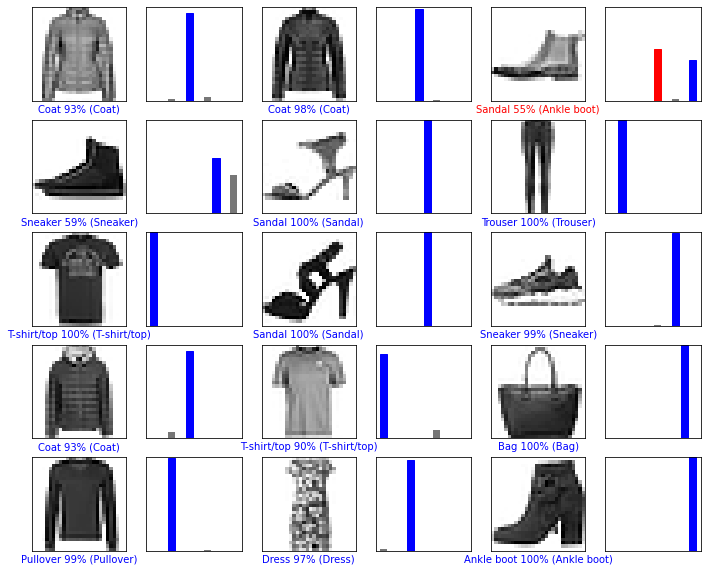

In [72]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
    
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)